# 聚类

熟悉各中聚类算法的调用
并用评价指标选择合适的超参数

In [1]:
#导入必要的工具包
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.decomposition import PCA
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
#读取训练数据
dpath = './data/'
train = pd.read_csv(dpath+'MNIST_train.csv')
train = train[::5]

y_train = train.label.values
X_train = train.drop("label",axis=1).values

In [23]:
#将像素值[0,255]  --> [0,1]
X_train = X_train / 255.0

In [24]:
# 原始输入的特征维数和样本数目
print('the shape of train_image: {}'.format(X_train.shape))

the shape of train_image: (8400, 784)


In [25]:
#对数据进行PCA降维
pca = PCA(n_components=0.75)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)

# 降维后的特征维数
print(X_train_pca.shape)

(8400, 33)


In [26]:
# 将训练集合拆分成训练集和校验集，在校验集上找到最佳的模型超参数（PCA的维数）
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train_pca,y_train, test_size = 0.2, random_state = 0)

In [27]:
#拆分后的训练集和校验集的样本数目
print(X_train_part.shape)
print(X_val.shape)

(6720, 33)
(1680, 33)


In [39]:
dbscan = DBSCAN(eps=1, min_samples=5)
pre = dbscan.fit_predict(X_train_part)
set(pre)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}

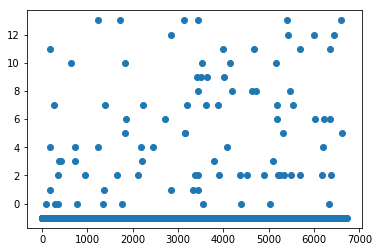

In [50]:
plt.scatter(np.arange(dbscan.labels_.shape[0]), dbscan.labels_)
#plt.scatter(np.arange(dbscan.labels_.shape[0]), y_train_part)

In [44]:
# 一个参数点（聚类数据为K）的模型，在校验集上评价聚类算法性能
def K_cluster_analysis(eps, X_train, y_train, X_val, y_val):
    start = time.time()
    
    print("DBSCAN begin with eps: {0}".format(eps));
    
    #DBSCAN,在训练集上训练
    dbscan = DBSCAN(eps=eps, min_samples=5)
    y_train_pred = dbscan.fit_predict(X_train_part)
    
    #以前两维特征打印训练数据的分类结果
    #plt.scatter(X_train[:, 0], X_train[:, 1], c=y_pred)
    #plt.show()

    # K值的评估标准
    #常见的方法有轮廓系数Silhouette Coefficient和Calinski-Harabasz Index
    #这两个分数值越大则聚类效果越好
    #CH_score = metrics.calinski_harabaz_score(X_train,mb_kmeans.predict(X_train))
    CH_score = metrics.silhouette_score(X_train, y_train_pred)
    
    #也可以在校验集上评估K
    v_score = metrics.v_measure_score(y_train, y_train_pred)
    
    end = time.time()
    print("CH_score: [{0}], v_score: [{1}] time elaps: [{2}]".format(CH_score, v_score, int(end-start)))
    
    return CH_score,v_score

In [45]:
# 设置超参数（聚类数目K）搜索范围
epss = [e for e in np.arange(0.5, 1.5, 0.3)]
CH_scores = []
v_scores = []
for eps in epss:
    ch,v = K_cluster_analysis(eps, X_train_part, y_train_part, X_val, y_val)
    CH_scores.append(ch)
    v_scores.append(v)

DBSCAN begin with eps: 0.5


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

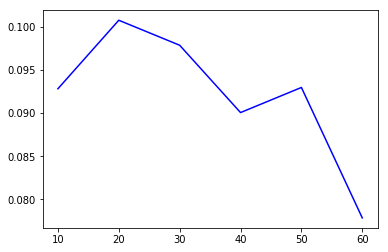

In [54]:
# 绘制不同PCA维数下模型的性能，找到最佳模型／参数（分数最高）
plt.plot(Ks, np.array(CH_scores), 'b-',)

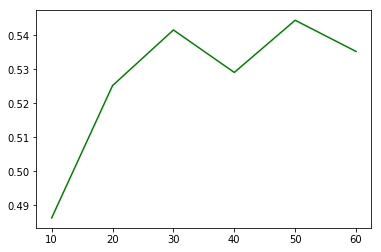

In [55]:
plt.plot(Ks, np.array(v_scores), 'g-')

两个指标的变化趋势类似

In [56]:
#显示聚类结果
#画出聚类结果，每一类用一种颜色
colors = ['b','g','r','k','c','m','y','#e24fff','#524C90','#845868']

n_clusters = 10
mb_kmeans = MiniBatchKMeans(n_clusters = n_clusters)
mb_kmeans.fit(X_train_pca)

y_train_pred = mb_kmeans.labels_
cents = mb_kmeans.cluster_centers_#质心


In [57]:
cents.shape

(10, 33)

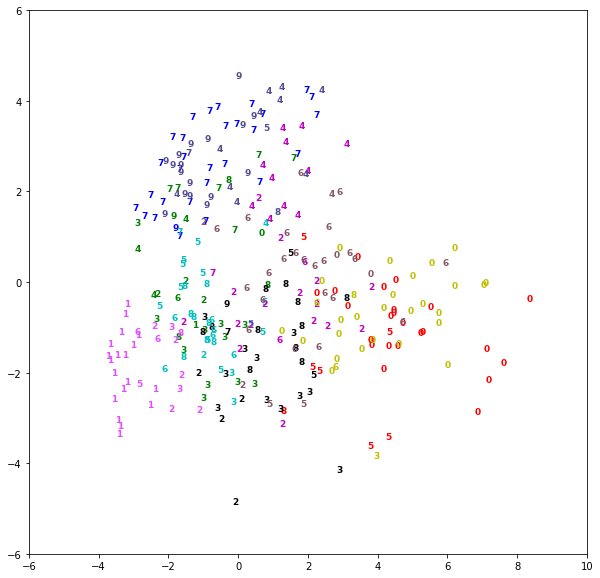

In [58]:
plt.figure(figsize=(10,10))
for i in range(n_clusters):
    index = np.nonzero(y_train_pred==i)[0]
    x1 = X_train_pca[index,0]
    x2 = X_train_pca[index,1]
    y_i = y_train[index]
    for j in range(len(x1)):
        if j < 30:  #每类打印20个
            plt.text(x1[j],x2[j],str(int(y_i[j])),color=colors[i],\
                fontdict={'weight': 'bold', 'size': 9})
    #plt.scatter(cents[i,0],cents[i,1],marker='x',color=colors[i],linewidths=12)

plt.axis([-6,10,-6,6])
plt.show()

效果并不好，7，9混在一个簇中